### **Wind Power Generation Forecasting Using Transformer-based Time Series Models**


Supervisor: Jenny Alexandra Cifuentes Quintero \\
Author: Teresa Oriol Guerra


**PREDICTION GRAPH FOR BEST GRU**

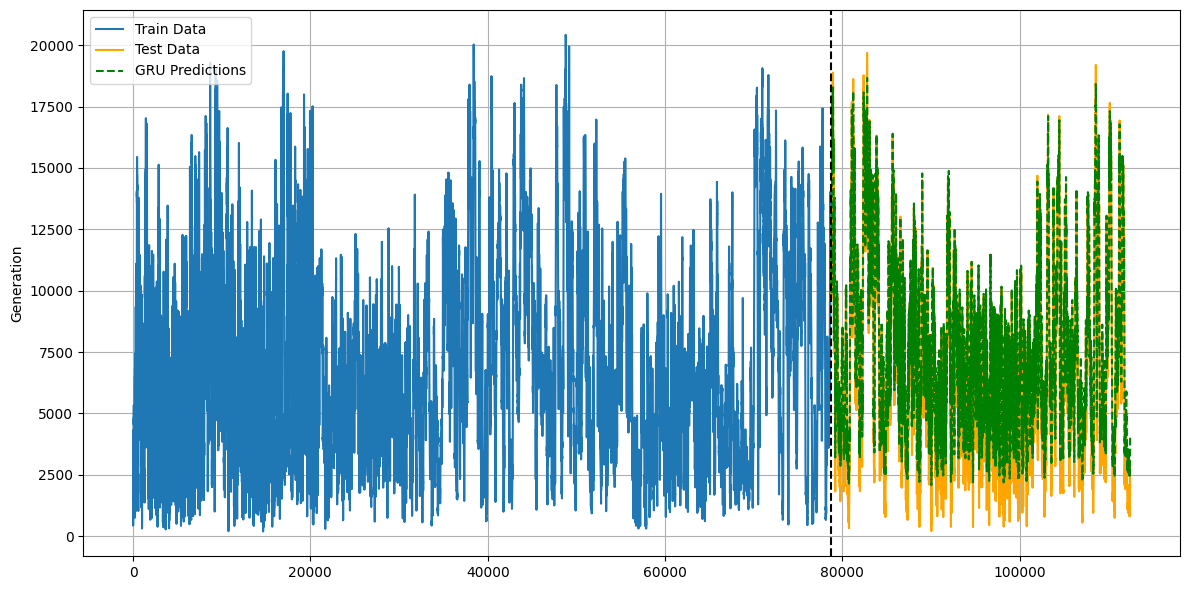

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar y normalizar los datos
df = pd.read_excel("df_final.xlsx")
data = df[['Generation']].dropna().values
mean, std = data.mean(), data.std()
data_norm = (data - mean) / std
tensor_data = torch.tensor(data_norm, dtype=torch.float32)

# Parámetros del mejor modelo GRU
seq_length = 36
batch_size = 16
hidden_dim = 1
num_layers = 3
dropout = 0.1

# Crear secuencias
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+1:i+seq_length+1]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# Separar en train/test
train_size = int(0.7 * len(tensor_data))
train_data = tensor_data[:train_size]
test_data = tensor_data[train_size:]

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

# Modelo GRU
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out)

model = GRUModel(1, hidden_dim, num_layers, dropout)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Entrenar
for epoch in range(10):
    model.train()
    for src, tgt in train_loader:
        optimizer.zero_grad()
        output = model(src)
        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()

# Predecir
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for src, tgt in test_loader:
        out = model(src)
        predictions.append(out[:, -1].squeeze().numpy())
        actuals.append(tgt[:, -1].squeeze().numpy())

y_pred = np.concatenate(predictions)
y_test = np.concatenate(actuals)

# Denormalizar
y_pred_denorm = (y_pred * std) + mean
y_test_denorm = (y_test * std) + mean

# Preparar para graficar
full_data = data.flatten()
test_plot = data[train_size + seq_length:].flatten()

pred_plot = np.empty_like(test_plot)
pred_plot[:] = np.nan
pred_plot[:len(y_pred_denorm)] = y_pred_denorm

# Graficar
plt.figure(figsize=(12,6))
plt.plot(full_data[:train_size], label="Train Data")
plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(test_plot)), test_plot, label="Test Data", color='orange')
plt.plot(np.arange(train_size + seq_length, train_size + seq_length + len(pred_plot)), pred_plot, label="GRU Predictions", linestyle='--', color='green')
plt.axvline(x=train_size, color='black', linestyle='--')
plt.ylabel("Generation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


PLOT WITH ZOOM FROM NOVEMBER 2023

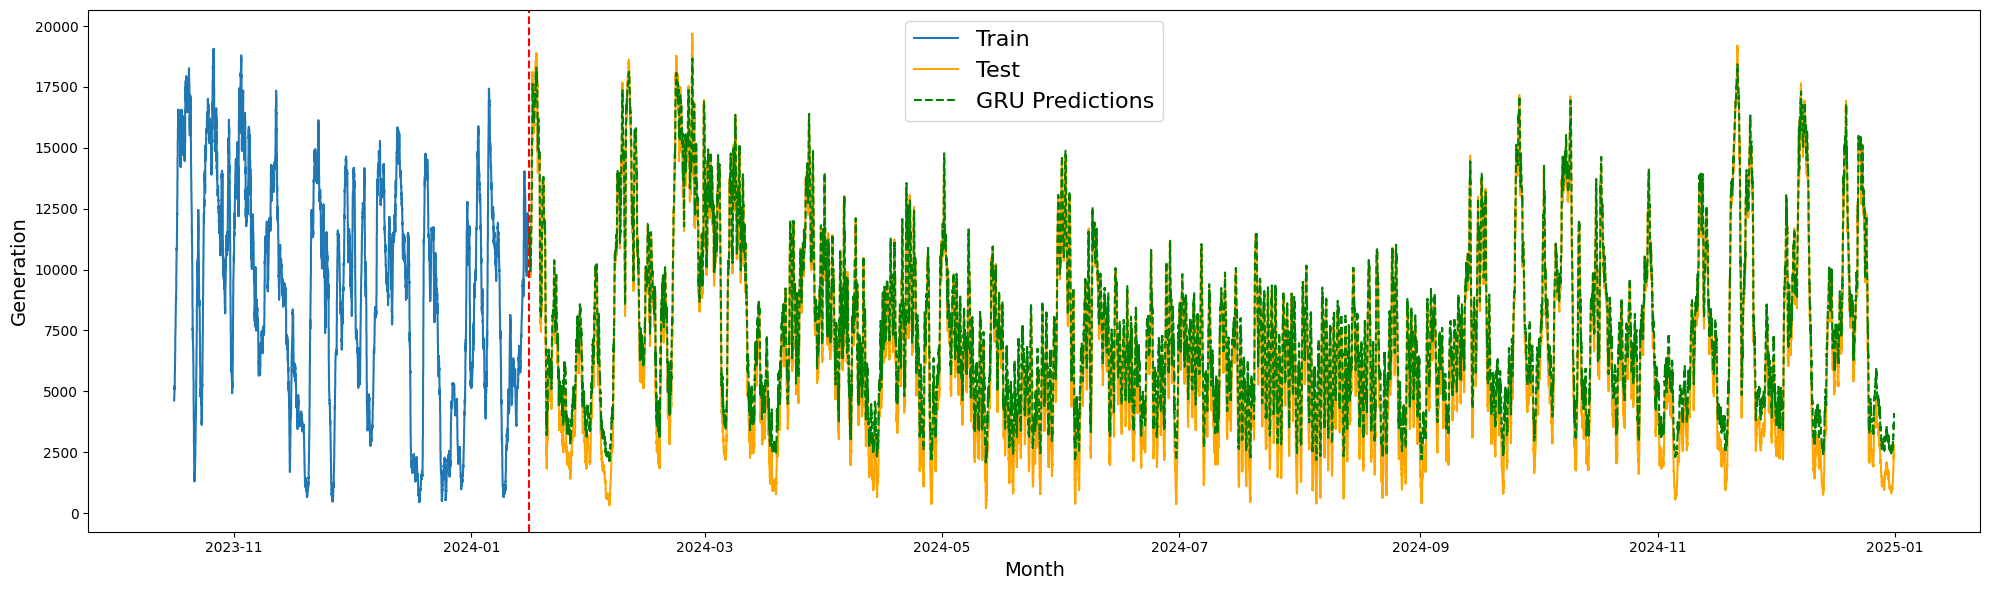

In [4]:
df['Fecha y Hora'] = pd.to_datetime(df['Fecha y Hora'])

# Obtener el índice donde comienzan las predicciones (inicio del test set)
pred_start_idx = train_size + seq_length

# Mostrar 1 año antes del inicio de las predicciones (8760 pasos horarios)
zoom_offset = 8760  # 365 días * 24 horas
zoom_start_idx = pred_start_idx - zoom_offset

# Preparar rango temporal para eje x
fechas = df['Fecha y Hora'].values
x_train = fechas[zoom_start_idx:pred_start_idx]
x_test = fechas[pred_start_idx:pred_start_idx + len(test_plot)]

plt.figure(figsize=(20,6))
plt.plot(x_train, data[zoom_start_idx:pred_start_idx], label="Train")
plt.plot(x_test, test_plot, label="Test", color='orange')
plt.plot(x_test, pred_plot, label="GRU Predictions", linestyle='--', color='green')
plt.axvline(x=fechas[pred_start_idx], color='red', linestyle='--')
plt.ylabel("Generation", fontsize=14)
plt.xlabel("Month", fontsize=14)
plt.legend(fontsize=16)
plt.tight_layout()
plt.show()